In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from collections import defaultdict
import json
import numpy as np
import pandas as pd
import re

In [2]:
def is_experiment_start(line):
    return line.startswith('evaluating for')

def skip_n_experiments(input_file, experiment_num):
    current_experiment = 0
    while current_experiment < experiment_num:
        line = input_file.readline()
        if is_experiment_start(line):
            current_experiment += 1
            
def get_metrics(line):
    regexp = re.compile(r'[a-zA-Z0-9_]+\: [0-9\.]+')
    result = {}
    for metric_str in regexp.findall(line):
        metric, value = metric_str.split(': ')
        result[metric] = float(value)
    return result
    
            
def parse_experiment(experiment_log):
    current_recommender = None
    result = []
    cnt =0
    metrics = []
    for line in experiment_log:
            if line.startswith('evaluating '):
                current_recommender = line.split(' ')[1]
                metrics = []
            if 'val_ndcg_at_40' in line:
                    metrics.append(get_metrics(line))
            try:
                experiment_results = json.loads(line)
                experiment_results['model_name'] =  current_recommender
                experiment_results['metrics_history'] = metrics
                result.append(experiment_results)
            except:
                pass
    return result

def get_data_from_logs(logfile, experiment_num):
    current_experiment = 0
    with open(logfile) as input_file:
        skip_n_experiments(input_file, experiment_num)
        experiment_log = []
        for line in input_file:
            if is_experiment_start(line):
                break
            else:
                experiment_log.append(line.strip())
        return parse_experiment(experiment_log)

In [3]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [3]:
experiment_logs = './results/booking_config_2021_01_16T14_07_20/stdout'
data = get_data_from_logs(experiment_logs, 0)


In [4]:
df = pd.DataFrame(data).set_index('model_name').sort_values('ndcg@40')
df

,precision@4,SPS@4,ndcg@4,ndcg@40,model_build_time,model_inference_time,model_metadata,metrics_history
model_name,,,,,,,,
top_recommender,0.012525,0.050100,0.028325,0.075407,0.109125,0.026073,{},[]
conditional_top_recommender,0.089763,0.355711,0.269893,0.346563,0.009286,0.031916,{},[]
transitions_chain_recommender,0.114228,0.456914,0.353790,0.438548,1.572902,12.820021,{},[]
APREC-GMLPHE-Lambdarank-256,0.127505,0.510020,0.409914,0.487177,30539.990019,32.086468,"{'epochs_trained': 47, 'best_val_ndcg': 0.5281...","[{'loss': 5.4684, 'ndcg_at_40': 0.18, 'Success..."


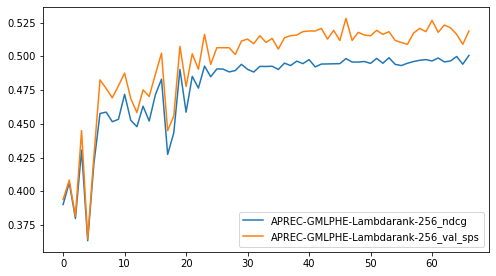

In [5]:
def get_metric(metric_history, metric_name):
    result = []
    for item in metric_history:
        try:
            result.append(item[metric_name])
        except:
            print(item)
    return result

plt.figure(figsize=(8, 4.5))
for recommender in data:
    if len(recommender['metrics_history']) > 0:
        history = recommender['metrics_history']
        ndcg = get_metric(history, 'ndcg_at_40')
        val_ndcg = get_metric(history, 'val_ndcg_at_40')
        
        success = get_metric(history, 'Success_at_4')
        val_success = get_metric(history, 'val_Success_at_4')
        
        plt.plot(val_ndcg, label=recommender['model_name'] + "››")
        plt.plot(val_success, label=recommender['model_name'] + "_val_sps")
plt.legend()


In [42]:
list(enumerate(pd.DataFrame(data[4]['metrics_history'])['ndcg_at_40']))

[(0, 0.1841),
 (1, 0.3207),
 (2, 0.3365),
 (3, 0.3457),
 (4, 0.3509),
 (5, 0.3547),
 (6, 0.3591),
 (7, 0.3617),
 (8, 0.3634),
 (9, 0.3675),
 (10, 0.3686),
 (11, 0.3715),
 (12, 0.3738),
 (13, 0.3749),
 (14, 0.376),
 (15, 0.3802),
 (16, 0.3797),
 (17, 0.3808),
 (18, 0.3826),
 (19, 0.3839),
 (20, 0.3845),
 (21, 0.385),
 (22, 0.3861),
 (23, 0.388),
 (24, 0.3898),
 (25, 0.3898),
 (26, 0.3911),
 (27, 0.3928),
 (28, 0.3934),
 (29, 0.3945),
 (30, 0.3952),
 (31, 0.3963),
 (32, 0.3967),
 (33, 0.3973),
 (34, 0.3978),
 (35, 0.3988),
 (36, 0.401),
 (37, 0.3999),
 (38, 0.4006),
 (39, 0.4025),
 (40, 0.4036),
 (41, 0.4036),
 (42, 0.403),
 (43, 0.4049),
 (44, 0.4062),
 (45, 0.4066),
 (46, 0.408),
 (47, 0.4075),
 (48, 0.4097),
 (49, 0.4097),
 (50, 0.4099),
 (51, 0.4109),
 (52, 0.4104),
 (53, 0.4127),
 (54, 0.4123),
 (55, 0.4121),
 (56, 0.4136),
 (57, 0.4146),
 (58, 0.4145),
 (59, 0.4142),
 (60, 0.4156),
 (61, 0.4166),
 (62, 0.417),
 (63, 0.4172),
 (64, 0.4176),
 (65, 0.4183),
 (66, 0.4198),
 (67, 0.4194

In [37]:
max(pd.DataFrame(data[4]['metrics_history'])['val_Success_at_4'])

0.5014

In [10]:
best = 0
time_since_best = []
for i in range (1, len(arr)):
    if arr[i] > arr[best]:
        best = i
    time_since_best.append(i - best)

In [12]:
plt.plot(time_since_best)